# Lab 4. Advanced Nets
#### Мартиненко Денис ФБ-42мп

## Завдання 1
Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

Датасети для перекладу можна брати тут: https://www.manythings.org/anki/

Тексти українською для навчання генеративних моделей: https://www.kaggle.com/datasets/mykras/ukrainian-texts

Приклади:
- https://keras.io/examples/nlp/neural_machine_translation_with_transformer/
- https://keras.io/examples/nlp/lstm_seq2seq/
- https://keras.io/examples/generative/lstm_character_level_text_generation/

In [42]:
import random

import keras
from keras.api import layers
from keras.api.layers import TextVectorization

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

In [43]:
def load_data(filepath, max_lines=None):
    pairs = []
    
    def process_line(line):
        # Process a single line to extract the English and Ukrainian pairs.
        parts = line.strip().split("\t")
        if len(parts) == 2:
            return parts[0], parts[1]
        return None
    
    with open(filepath, "r", encoding="utf-8") as file:
        for i, line in enumerate(file):
            if max_lines and i >= max_lines:
                break
            result = process_line(line)
            if result:
                pairs.append(result)
                
    return pairs

file_path = "ukr.txt"
text_pairs = load_data(file_path, max_lines=150_000)


In [45]:
for i in range(0, 10):
    print(random.choice(text_pairs))

('It was nice to see you again.', 'Було приємно знову з вами побачитися.')
("I didn't see anybody.", 'Я нікого не побачив.')
("I'm learning French now.", 'Я зараз вивчаю французьку мову.')
('He looked at his watch.', 'Він подивився на годинник.')
('I need your answer by the end of the day.', 'Мені потрібна ваша відповідь до кінця дня.')
("I'm very nervous today.", 'Я сьогодні дуже нервовий.')
('Is Tom planning to do that?', 'Том планує це зробити?')
("Don't you want some help?", 'Хіба ти не хочеш отримати допомогу?')
('How can I quit this job?', 'Як я можу кинути цю роботу?')
('Do you want to work for us?', 'Ти хочеш на нас працювати?')


In [48]:
shuffled_pairs = text_pairs.copy()
random.shuffle(shuffled_pairs)

# Calculate the number of validation samples (15% of total)
validation_count = len(shuffled_pairs) // 10  # 15% of the total number of pairs
train_count = len(shuffled_pairs) - 2 * validation_count

# Split the shuffled list into training, validation, and test sets
train_set = shuffled_pairs[:train_count]
validation_set = shuffled_pairs[train_count:train_count + validation_count]
test_set = shuffled_pairs[train_count + validation_count:]

print(f"Total pairs: {len(shuffled_pairs)}")
print(f"Training pairs: {len(train_set)}")
print(f"Validation pairs: {len(validation_set)}")
print(f"Test pairs: {len(test_set)}")

Total pairs: 150000
Training pairs: 120000
Validation pairs: 15000
Test pairs: 15000


In [54]:
import string
import re

VOCAB_SIZE = 15000
SEQUENCE_LENGTH = 15
BATCH_SIZE = 64

strip_chars = string.punctuation.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH,
)
ukr_vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_set]
train_spa_texts = [pair[1] for pair in train_set]
eng_vectorization.adapt(train_eng_texts)
ukr_vectorization.adapt(train_spa_texts)


In [55]:
def format_dataset(eng, ukr):
    eng = eng_vectorization(eng)
    ukr = ukr_vectorization(ukr)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": ukr[:, :-1],
        },
        ukr[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ukr_texts = list(ukr_texts)
    
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, ukr_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

train_ds = make_dataset(train_set)
val_ds = make_dataset(validation_set)

In [56]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 15)
inputs["decoder_inputs"].shape: (64, 15)
targets.shape: (64, 15)


In [59]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = keras.api.ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = keras.api.ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = keras.api.ops.arange(sequence_length)[:, None]
        j = keras.api.ops.arange(sequence_length)
        mask = keras.api.ops.cast(i >= j, dtype="int32")
        mask = keras.api.ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = keras.api.ops.concatenate(
            [keras.api.ops.expand_dims(batch_size, -1), keras.api.ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return keras.api.ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


In [58]:
EMBEDDINGS_DIM = 128
LATENT_DIM = 512
NUM_HEADS = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDINGS_DIM)(encoder_inputs)
encoder_outputs = TransformerEncoder(EMBEDDINGS_DIM, LATENT_DIM, NUM_HEADS)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBEDDINGS_DIM), name="decoder_state_inputs")
x = keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDINGS_DIM)(decoder_inputs)
x = TransformerDecoder(EMBEDDINGS_DIM, LATENT_DIM, NUM_HEADS)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)


In [60]:
epochs = 5

transformer.summary()
transformer.compile(
    "rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, None, 128) │  1,920,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, None, 128) │  1,920,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    659,712 │ embedding_11[0][… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │  1,187,456 │ embedding_12[0][… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, None, 128) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, None,      │  1,935,000 │ dropout_11[0][0]  │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,622,168 (29.08 MB)

 Trainable params: 7,622,168 (29.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7795 - loss: 2.1560

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 24ms/step - accuracy: 0.7795 - loss: 2.1554 - val_accuracy: 0.8381 - val_loss: 1.1312
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.8379 - loss: 1.1376 - val_accuracy: 0.8625 - val_loss: 0.8920
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.8597 - loss: 0.9373 - val_accuracy: 0.8728 - val_loss: 0.8269
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.8696 - loss: 0.8603 - val_accuracy: 0.8781 - val_loss: 0.7930
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.8757 - loss: 0.8219 - val_accuracy: 0.8812 - val_loss: 0.7842


In [61]:
transformer.save("transformer_eng_urk_gpu_trained.h5")

In [71]:
ukr_vocab = ukr_vectorization.get_vocabulary()
ukr_index_lookup = {index: word for index, word in enumerate(ukr_vocab)}
max_decoded_length = 15

def translate_sentence(input_sentence):
    tokenized_input = eng_vectorization([input_sentence])
    decoded = "[start]"
    
    for i in range(max_decoded_length):
        tokenized_output = ukr_vectorization([decoded])[:, :-1]
        
        predictions = transformer({
            "encoder_inputs": tokenized_input,
            "decoder_inputs": tokenized_output,
        })
        
        token_index = keras.api.ops.convert_to_numpy(
            keras.api.ops.argmax(predictions[0, i, :])
        ).item(0)
        
        token = ukr_index_lookup[token_index]
        decoded += f" {token}"
    
    return decoded

english_sentences = [pair[0] for pair in test_set]
for i in range(15):
    eng_sentence = random.choice(english_sentences)
    translated_sentence = translate_sentence(eng_sentence)
    print(eng_sentence, translated_sentence)

No one can help you, Tom. [start] Том може тобі допомогти           
Accidents are inevitable. [start] Неминучі аварії          
I was afraid I'd lose you. [start] я боюся я програю          
Please memorize this. [start] запам'ятай будь ласка           
Can I open the window? [start] я можу відчинити вікно           
I do pretty well. [start] я справився добре             
You must tell me. [start] мені повинен сказати            
I can teach you how to drive. [start] я можу тебе водити           
Tom will be a teacher. [start] Том буде учитель            
Forget it. It's too risky. [start]   Забудь про це ризиковано            
Who are you phoning now? [start] зараз телефонуєш              
Please put that on the table. [start] це на столі будь ласка          
I like the rain and the snow. [start] Я люблю дощ та сніг             
Come here. I need to tell you something. [start] мені потрібно щось тобі сказати          
I think that I have a cold. [start] я думаю я холод            


## Завдання 2
Проведіть експерименти з моделями бібліотеки Hugging Face (раніше - Hugging Face Transformers, https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

Приклади:
- https://github.com/natsakh/Data-Analysis/tree/main/Pr_8
- https://huggingface.co/learn/nlp-course/chapter1/3?fw=pt
- https://huggingface.co/learn/nlp-course/chapter2/2?fw=pt

Знайдіть українські мовні моделі, наведіть приклади роботи з ними. 

In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model="benjamin/gpt2-large-wechsel-ukrainian", temperature=0.7)

result = pipe("Здолає дорогу той,")
print(result)

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Здолає дорогу той, хто йде».\n«Якщо ми не будемо молитися - не матимемо життя і будемо жити в гробах», - говорив апостол Павло. І саме тому ми повинні молитися. А молитва - це розмова з Богом.\nУ'}]


In [17]:
pipe = pipeline("text-generation", model="benjamin/gpt2-large-wechsel-ukrainian", temperature=1.0)

result = pipe("Здолає дорогу той,")
print(result)

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Здолає дорогу той, хто йде» (Мт. 7.13-14). Про це добре знають діти нашого міста. Це діти учасників АТО з багатодітних сімей, діти, чиї батьки загинули, захищаючи незалежність і територіальну цілісність нашої країни. Вони'}]


In [15]:
pipe = pipeline("text-generation", model="benjamin/gpt2-large-wechsel-ukrainian", temperature=1.2)

result = pipe("Здолає дорогу той,")
print(result)

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Здолає дорогу той, хто йде», під таким девізом 6 травня в спортивній залі школи відбулись районні змагання Спартакіади школярів з баскетболу. У даних змаганнях приймало участь шість команд, і наша показала непогані результати і виборола перемогу з рахунком 38'}]


In [23]:
pipe = pipeline("text-generation", model="benjamin/gpt2-large-wechsel-ukrainian", temperature=1.0, min_length=30)

result = pipe("Екстрені відключення світла")
print(result)

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Екстрені відключення світла, що здійснюються без попереджень і попередження у вигляді гудків, гудінням і сирен, можуть спричинити серйозну і навіть серйозну загрозу для життя і здоров'я людей.\nПеревіряти справність електроустановок споживачів, електрообладнання"}]


In [24]:
pipe = pipeline("text-generation", model="benjamin/gpt2-large-wechsel-ukrainian", temperature=1.0, min_length=30)

result = pipe("Іноді ми знаходимося у незрозумілій ситуації, але")
print(result)

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Іноді ми знаходимося у незрозумілій ситуації, але не маємо жодного плану дій, що діяти потрібно лише тому, що так написано у якомусь законі, що це є наше право. У цьому випадку людина є заручником не якоїсь абстрактної ситуації, а конкретної'}]


In [ ]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model="ukr-models/uk-summarizer", min_length=50)

input_text = """
Українська модель GPT-2, базована на трансформерах, може генерувати тексти та виконувати різноманітні задачі. 
Цей підхід забезпечує адаптацію до різних задач, таких як підсумування тексту, класифікація, переклад та багато інших. 
Трансформери стали основою багатьох передових досягнень у обробці природної мови.
"""
print(pipe(input_text))

input_text = """
⚔️ Найбільш активні ділянки в районі селища Велика Новосілка: північніше — Новий Комар, та південніше — Нескучне.

🇷🇺 В Новий Комар кацапи намагаються заходити піхотою, насичуватися в селі, щоб закріпитися в ньому. Сили Оборони в свою чергу докладають максимальних зусиль не дати цього зробити противнику і здійснюють ураження по піхоті, яка ховається в будинках. Часто роблять це досить успішно, але ресурс ворога нескінченний, що ускладнює ситуацію.

🏹 Після зайняття населених пунктів Сторожове та Благодатне, кацапи підтягують свої ресурси в даний район для накопичення і подальшого просування. Наступна точка, якій вони приділяють увагу — Нескучне. Також московити пробують рухатися в бік траси з Гуляйполя на Велику Новосілку. Тривають спроби зупинити ворога. 

🧱 А на східній частині від Великої Новосілки кацапи копають фортифікаційні споруди і насичують їх піхотою. Подальші їх рухи ми побачимо вже з часом.  
"""
result = pipe(input_text)
print(pipe(input_text))


[{'generated_text': 'Українська модель GPT-2, базована на трансформерах, стала основою багатьох'}]
[{'generated_text': 'У Московській області кацапи намагаються закріпитися в селі Велик'}]


In [ ]:
pipe = pipeline("text2text-generation", model="ukr-models/uk-summarizer", min_length=50)
input_text = """
Вочевидь, зараз не всі пригадають цю серпневу дату – вісімнадцяте святкування Дня Незалежності України. Відлік десятилітньої історії Вишиванкового фестивалю розпочався саме тоді, коли сімдесят дев’ять людей, убраних у виши́ванки, утворили вздовж Потьомкінських сходів так званий «живий ланцюг». Амбітні плани організаторів повністю виправдалися: він сягнув-таки берега моря. Простягаючись білою ниткою від п’єдесталу пам’ятника Рішельє, ланцюг із року в рік ставав усе довшим, а разом із цим зростало й усвідомлення Одеси як українського міста. Зростало настільки, що в 2014 році, незважаючи на невпинну зливу, для участі в акції «Вишиванковий ланцюг» вишикувалася півторатисячна черга, утворивши нескінченне живе море виши́ванок.

Подальші два роки запам’яталися встановленням нових рекордів, адже́ кількість учасників збільшилася вдвічі. До речі, дюк де Рішельє також долучається до цієї події. Четвертий рік поспіль святковий гардероб герцога поповнюється найрізноманітнішими виши́ванками: блакитно-синій і яскраво-червоний, жовтогарячий і ніжно-зелений – ось палітра його ви́шитих візерунків.

Уже вдеся́те майорить Приморський бульвар синьо-жовтими барвами, і вже вкотре ми збираємось у самому серці Одеси, щоб помилуватися показом автентичного вбрання, написати диктант просто неба, концентруючи  нашу енергію й демонструючи всім як свою єдність, так і свою любов до рідного міста та своєї країни.
"""
result = pipe(input_text)
print(pipe(input_text))


[{'generated_text': 'У серпні Одеса відзначає День Незалежності України. Для '}]


In [2]:
from transformers import pipeline

# Initialize the translation pipeline
pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk")

# Translate English text to Ukrainian
text = "There was another man his father talked about—one Francis J. Grund, a famous newspaper correspondent and lobbyist at Washington, who possessed the faculty of unearthing secrets of every kind, especially those relating to financial legislation."
result = pipe(text)

# Print the translated text
print(result[0]['translation_text'])

Device set to use cuda:0


Ще один чоловік, про якого говорив його батько, - Френсіс Дж. Ґрунд, відомий кореспондент і лобіст у Вашингтоні, який мав випередження різних таємниць, особливо тих, що стосуються фінансового законодавства.


In [4]:
from transformers import pipeline

# Initialize the translation pipeline
pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk")

# Translate English text to Ukrainian
text = """
Being ambitious to get ahead socially and financially, he was very careful of whom or with whom he talked. He was as much afraid of expressing a rabid or unpopular political or social opinion as he was of being seen with an evil character, though he had really no opinion of great political significance to express. He was neither anti- nor pro-slavery, though the air was stormy with abolition sentiment and its opposition. He believed sincerely that vast fortunes were to be made out of railroads if one only had the capital and that curious thing, a magnetic personality—the ability to win the confidence of others.
"""
result = pipe(text)

# Print the translated text
print(result)

Device set to use cuda:0


[{'translation_text': 'Будучи честолюбним, щоб досягти успіху в соціальному та фінансовому плані, він був дуже обережним щодо кого або з ким він говорив. Він так само боявся виразити шалену або непопулярну політичну або соціальну опінію, як він був бачений з лихим характером, хоча він насправді не мав жодної думки про велике політичне значення, щоб виразити. Він не був ні проти- ні про-рабства, хоча повітря було бурхливо з спростовуючими почуттями і його протистояння.'}]


## Завдання 3
Завдання щодо генерації або стилізації зображень (на вибір)
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/Diffusion).

Датасети: можна брати CIFAR-100, Fashion MNIST або тут: https://www.kaggle.com/tags/image-data

Приклади: 
- https://github.com/natsakh/Data-Analysis/tree/main/Pr_9
- https://keras.io/examples/generative/neural_style_transfer/
- https://keras.io/examples/generative/ddim/

In [14]:
from torch import nn

# Defining architecture of DCGAN for image generation of Fashion MNIST dataset

class Generator(nn.Module):
    def __init__(self, noise_channels, image_channels, features):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_channels, features*16, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),

            nn.ConvTranspose2d(features*16, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.ReLU(),

            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),

            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            nn.ConvTranspose2d(features*2, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, image_channels, features):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# Hyperparameters and variables
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
IMAGE_SIZE = 64
EPOCHS = 50
image_channels = 1
noise_channels = 256
gen_features = 64
disc_features = 64

device = torch.device("cuda")

data_transforms = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
])

# Load dataset 
dataset = FashionMNIST(root="dataset/", train=True, transform=data_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create models
gen_model  = Generator(noise_channels, image_channels, gen_features).to(device)
disc_model = Discriminator(image_channels, disc_features).to(device)

# Setup optimizers and a loss function for both models
gen_optimizer = optim.Adam(gen_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(disc_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Make both models train
gen_model.train()
disc_model.train()

# Labels for fake images and real images for the discriminator
fake_label = 0
real_label = 1

# Defining a fixed noise 
fixed_noise = torch.randn(64, noise_channels, 1, 1).to(device)
step = 0

print("Start training...")
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.to(device)
        batch_size = data.shape[0]

        # Train discriminator model on real data
        disc_model.zero_grad()
        label = (torch.ones(batch_size) * 0.9).to(device)
        output = disc_model(data).reshape(-1)
        real_disc_loss = criterion(output, label)
        d_x = output.mean().item()

        # Train discriminator model on fake data
        noise = torch.randn(batch_size, noise_channels, 1, 1).to(device)
        fake = gen_model(noise)
        label = (torch.ones(batch_size) * 0.1).to(device)
        output = disc_model(fake.detach()).reshape(-1)
        fake_disc_loss = criterion(output, label)

        # Calculate final discriminator loss
        disc_loss = real_disc_loss + fake_disc_loss
        # Apply optimizer and gradient
        disc_loss.backward()
        disc_optimizer.step()

        # Train generator model
        gen_model.zero_grad()
        label = torch.ones(batch_size).to(device)
        output = disc_model(fake).reshape(-1)
        gen_loss = criterion(output, label)
        
        # Apply the optimizer and gradient
        gen_loss.backward()
        gen_optimizer.step()

        if batch_idx % 50 == 0:
            step += 1

            print(f"Epoch: {epoch} ------ Batch: {batch_idx}/{len(dataloader)} ------ Disc loss: {disc_loss:.4f} ------ Gen loss: {gen_loss:.4f}")

Start training...
Epoch: 0 ------ Batch: 0/235 ------ Disc loss: 1.4344 ------ Gen loss: 8.3769
Epoch: 0 ------ Batch: 50/235 ------ Disc loss: 0.7866 ------ Gen loss: 1.3680
Epoch: 0 ------ Batch: 100/235 ------ Disc loss: 0.9569 ------ Gen loss: 1.2516
Epoch: 0 ------ Batch: 150/235 ------ Disc loss: 1.0437 ------ Gen loss: 1.5286
Epoch: 0 ------ Batch: 200/235 ------ Disc loss: 1.1939 ------ Gen loss: 0.5855
Epoch: 1 ------ Batch: 0/235 ------ Disc loss: 1.2695 ------ Gen loss: 1.9986
Epoch: 1 ------ Batch: 50/235 ------ Disc loss: 1.2605 ------ Gen loss: 1.2880
Epoch: 1 ------ Batch: 100/235 ------ Disc loss: 1.3082 ------ Gen loss: 1.1106
Epoch: 1 ------ Batch: 150/235 ------ Disc loss: 1.3278 ------ Gen loss: 1.2615
Epoch: 1 ------ Batch: 200/235 ------ Disc loss: 1.6797 ------ Gen loss: 1.4772
Epoch: 2 ------ Batch: 0/235 ------ Disc loss: 1.3246 ------ Gen loss: 1.6695
Epoch: 2 ------ Batch: 50/235 ------ Disc loss: 1.2780 ------ Gen loss: 1.1502
Epoch: 2 ------ Batch: 100/235 

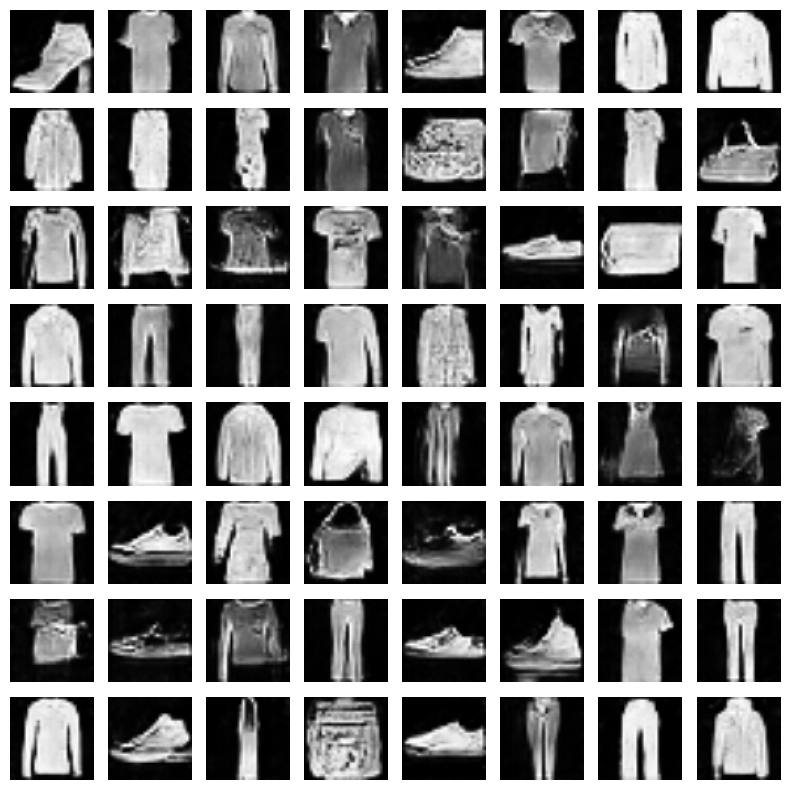

In [33]:
import matplotlib.pyplot as plt

gen_model.eval()

with torch.no_grad():
    # Generating random noise
    test_noise = torch.randn(64, noise_channels, 1, 1).to(device)
    generated_images = gen_model(test_noise).cpu()

# Denormalize images
generated_images = (generated_images + 1) / 2  # Scale images to [0, 1]

# Plot the generated images
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    # Show single-channel images (grayscale)
    ax.imshow(generated_images[i, 0], cmap='gray')

plt.tight_layout()
plt.show()

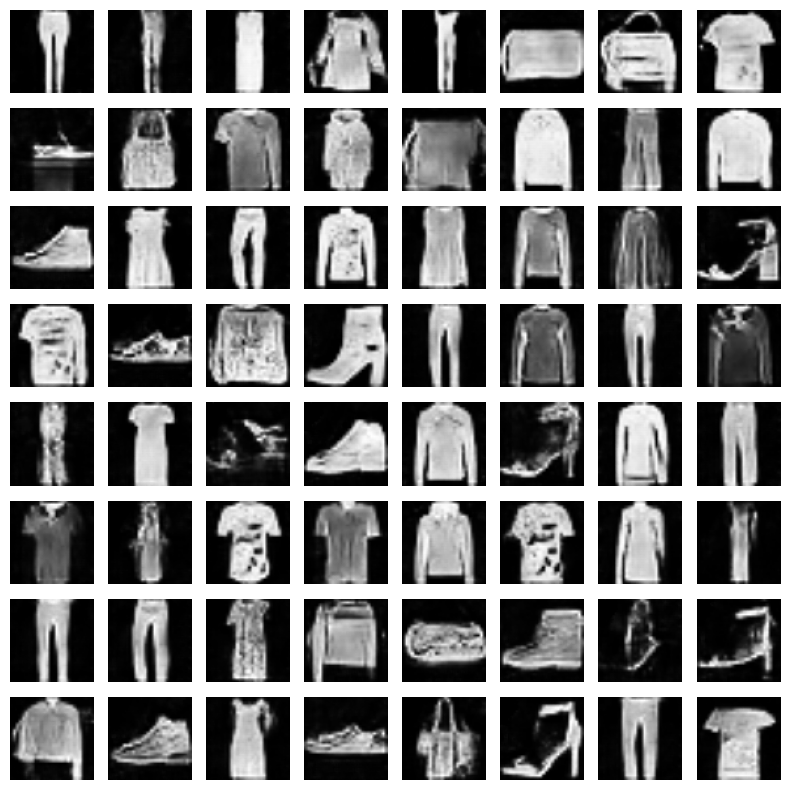

In [34]:
with torch.no_grad():
    test_noise = torch.randn(64, noise_channels, 1, 1).to(device)
    generated_images = gen_model(test_noise).cpu()

generated_images = (generated_images + 1) / 2

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.imshow(generated_images[i, 0], cmap='gray')

plt.tight_layout()
plt.show()

In [35]:
torch.save(gen_model, "gen_model.pth")
torch.save(disc_model, "disc_model.pth")